In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers


from utils import windowed_dataset, build_basic_lstm,split_train_test,split_train_test_val, plot_report
from config import *

%matplotlib inline
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import datetime

import os

import mlflow
mlflow.set_tracking_uri("http://mlflow_server:5001")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

mpl.rcParams['figure.figsize'] = [35.0, 7.0]

today=datetime.date.today().strftime("%Y%m%d")
today = 20220905
coefficients=17

results_path = "/data/elekin/data/results/handwriting"

rd_filename='residues_{}_{}.csv'.format(coefficients, today)
rd_feat_filename='residues_feat_{}_{}.csv'.format(coefficients, today)
rd_feat_norm_filename='residues_feat_norm_{}_{}.csv'.format(coefficients, today)

r_filename='radius_{}.csv'.format(today)
r_feat_filename='radius_feat_{}.csv'.format(today)
r_feat_norm_filename='radius_feat_norm_{}.csv'.format(today)

binary_labels_filename ='binary_labels_20220903.csv'.format(today)

import seaborn as sns
sns.set_theme(style="whitegrid")
mpl.style.use('seaborn-notebook')

Current tracking uri: http://mlflow_server:5001


In [2]:
rd_df = pd.read_csv(os.path.join(results_path, rd_filename), index_col=0)
binary_labels = pd.read_csv(os.path.join(results_path, binary_labels_filename), index_col=0)

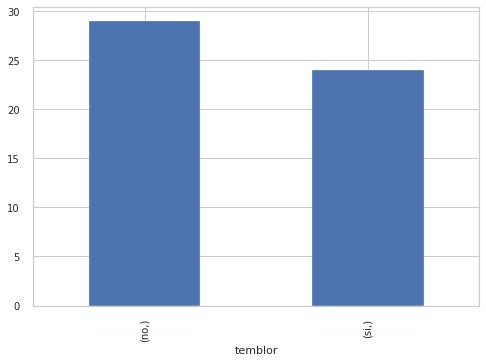

In [3]:
_=binary_labels.value_counts().plot.bar()

In [4]:
x=rd_df.values.astype('float32')
y=(binary_labels == 'si').values.astype('int8').reshape(-1,1)
x.shape

(53, 4096)

Window function is applied to Dataset objects. Same windows lenghts for each time series corresponding to each subject are built asigning the rigth label. Then they are included in same Dataset object.

In [5]:
#windowing parameters
num_features = x.shape[1]
window_size = int(num_features/5 + 1)
shuffle_buffer = num_features
batch_size = 1

In [6]:
features=tf.data.Dataset.from_tensor_slices(x)
labels=(y)

In [7]:
#series, window_size, batch_size,label
for i,features in enumerate(x):
    new = windowed_dataset(features,window_size,batch_size,labels[i])
    if i>0:
        dataset = tf.data.Dataset.concatenate(dataset,new)
    else:
        dataset = new
        
dataset.cache()
dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.int8, name=None))

In [8]:
# DATASET_SIZE = int((num_features/window_size)*50)
# #TODO import from utils API
# train_size = int(0.7 * DATASET_SIZE)
# val_size = int(0.15 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)

# full_dataset = dataset
# full_dataset = full_dataset.shuffle(DATASET_SIZE, seed=seed)
# train_dataset = full_dataset.take(train_size).batch(mini_batch_size).prefetch(2).cache()
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size).batch(mini_batch_size).prefetch(2).cache()
# test_dataset = test_dataset.take(test_size).batch(mini_batch_size).prefetch(2).cache()

In [9]:
DATASET_SIZE = int((num_features/window_size)*50)
train_dataset, val_dataset, test_dataset = split_train_test_val(dataset, DATASET_SIZE, train_ratio=0.67, val_ratio=0.17, test_ratio=0.16, shuffle_buffer=DATASET_SIZE, seed=seed, mini_batch_size=64)

In [10]:
DATASET_SIZE

249

In [11]:
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-4),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=True)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [12]:
size_histories = {}
mini_batch_size = 512

In [13]:
# # LSTM basic architectures --> #TODO import from utils API
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),input_shape=(window_size,)))
# model.add(tf.keras.layers.LSTM(8, activation=tf.nn.tanh, return_sequences=False))
# # model.add(tf.keras.layers.Dropout(dropout))
# model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# size_histories['lstm/windows'] = compile_and_fit(model, train_dataset, 
#                                           val_dataset,
#                                           "fcnn/tiny", 
# #                                               optimizer=get_optimizer(),
#                                           optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
# #                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
#                                           max_epochs=5)

In [14]:
# print("\n#######################Evaluation###########################")
# # Evaluate the model on the test data using `evaluate`
# print('train acc:', max(size_histories['lstm/windows'].history["accuracy"]))
# print('val acc:', max(size_histories['lstm/windows'].history["val_accuracy"]))

(0.0, 1.5)

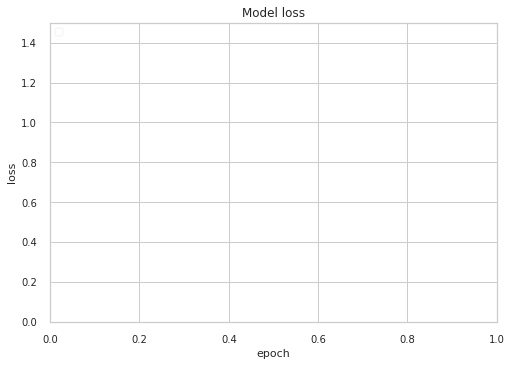

In [15]:
plot_report(size_histories, metric = 'loss')
plt.ylim(0., 1.5)

(0.4, 1.05)

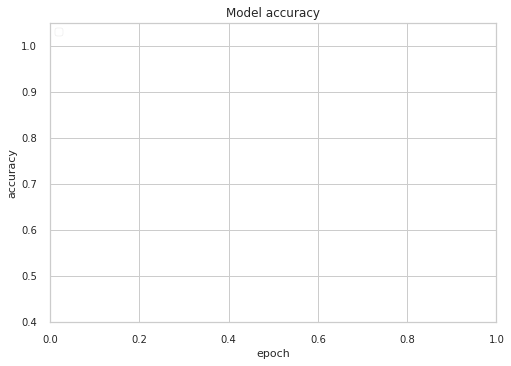

In [16]:
plot_report(size_histories, metric = 'accuracy')
plt.ylim(0.4, 1.05)

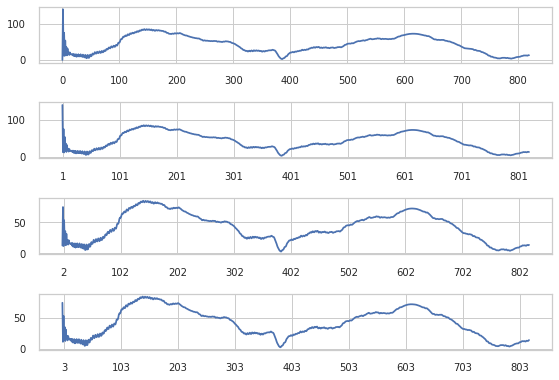

In [17]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()

i=0
for (x,y),ax in zip(dataset.take(4), axes):
    ax.plot(x.numpy(), color=colors[y.numpy()[0]])
    ax.set_xticks(range(i,window_size,100))
    input_tensor=tf.expand_dims(x, axis=1)
    i+=1

In [18]:
#model.evaluate(test_dataset)[1]

In [19]:
#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_residues_20220827_17.csv") #TODO automate
features = features.set_index(features.columns[0])
labels = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_residues_20220827_17_labels.csv") #TODO automate
labels = labels.set_index(labels.columns[0])
print("Loaded data from CSV")
features.head(10)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,7.349452e-15,-13.291940,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,...,8.309032,7.649810,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316
C01_1,-1.329194e+01,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,...,7.649810,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390
C01_1,1.024601e+00,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,...,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240
C01_1,1.016114e+01,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,...,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966
C01_1,3.315941e+00,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,...,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017
C01_1,-3.097414e+00,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,...,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796
C01_1,1.440666e+00,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,8.975251,...,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796,14.565094
C01_1,7.129718e+00,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,8.975251,9.042866,...,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796,14.565094,16.379218
C01_1,4.707049e+00,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,8.975251,9.042866,6.266289,...,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796,14.565094,16.379218,17.498379


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(labels.values.ravel())
y = LabelEncoder().fit_transform(labels.values.ravel())
y.shape

(214491,)

In [21]:
X=features.values
X.shape

(214491, 50)

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
mini_batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

281 train batches and 139 test batches of 512 mini batch size and 1 steps per epoch


In [24]:
mlflow.set_experiment("archimedes-dl-w")
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    num_features = x_train.shape[1]
    tiny = tf.keras.models.Sequential([
        tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

    size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                                  test_dataset,
                                                  "fcnn/tiny", 
                                                   optimizer=get_optimizer(),
    #                                             optimizer=tf.keras.optimizers.Adam(lr), 
    #                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                  max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))
mlflow.end_run()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.6040 - accuracy: 0.3957 - val_loss: 0.6055 - val_accuracy: 0.3942
Epoch 2/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.3963 - val_loss: 0.6045 - val_accuracy: 0.3950
Epoch 3/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.4484 - val_loss: 0.3943 - val_accuracy: 0.6047
Epoch 4/10000
2

Epoch 51/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3285 - accuracy: 0.6421 - val_loss: 0.3257 - val_accuracy: 0.6460
Epoch 52/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3289 - accuracy: 0.6423 - val_loss: 0.3258 - val_accuracy: 0.6465
Epoch 53/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3287 - accuracy: 0.6424 - val_loss: 0.3253 - val_accuracy: 0.6469
Epoch 54/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.3267 - accuracy: 0.6441 - val_loss: 0.3253 - val_accuracy: 0.6473
Epoch 55/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3262 - accuracy: 0.6443 - val_loss: 0.3248 - val_accuracy: 0.6469
Epoch 56/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.6434 - val_loss: 0.3250 - val_accuracy: 0.6476
Epoch 57/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3257 - accuracy: 0.6450 - val_loss: 0.3239 -

281/281 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.6548 - val_loss: 0.3163 - val_accuracy: 0.6558
Epoch 108/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.6552 - val_loss: 0.3161 - val_accuracy: 0.6560
Epoch 109/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3162 - accuracy: 0.6555 - val_loss: 0.3160 - val_accuracy: 0.6557
Epoch 110/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3160 - accuracy: 0.6555 - val_loss: 0.3159 - val_accuracy: 0.6558
Epoch 111/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.6557 - val_loss: 0.3158 - val_accuracy: 0.6559
Epoch 112/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3158 - accuracy: 0.6558 - val_loss: 0.3156 - val_accuracy: 0.6560
Epoch 113/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3156 - accuracy: 0.6561 - val_loss: 0.3155 - val_accu

Epoch 163/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3063 - accuracy: 0.6639 - val_loss: 0.3067 - val_accuracy: 0.6640
Epoch 164/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3060 - accuracy: 0.6640 - val_loss: 0.3062 - val_accuracy: 0.6641
Epoch 165/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3055 - accuracy: 0.6642 - val_loss: 0.3060 - val_accuracy: 0.6645
Epoch 166/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.3043 - accuracy: 0.6644 - val_loss: 0.3052 - val_accuracy: 0.6651
Epoch 167/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3039 - accuracy: 0.6646 - val_loss: 0.3049 - val_accuracy: 0.6654
Epoch 168/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3037 - accuracy: 0.6647 - val_loss: 0.3046 - val_accuracy: 0.6655
Epoch 169/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.3035 - accuracy: 0.6649 - val_loss: 0

Epoch 219/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2917 - accuracy: 0.6738 - val_loss: 0.2925 - val_accuracy: 0.6733
Epoch 220/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2916 - accuracy: 0.6740 - val_loss: 0.2924 - val_accuracy: 0.6735
Epoch 221/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.6740 - val_loss: 0.2923 - val_accuracy: 0.6737
Epoch 222/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2913 - accuracy: 0.6740 - val_loss: 0.2922 - val_accuracy: 0.6739
Epoch 223/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2912 - accuracy: 0.6742 - val_loss: 0.2921 - val_accuracy: 0.6740
Epoch 224/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2911 - accuracy: 0.6743 - val_loss: 0.2920 - val_accuracy: 0.6740
Epoch 225/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2910 - accuracy: 0.6744 - val_loss: 0

Epoch 275/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2861 - accuracy: 0.6784 - val_loss: 0.2873 - val_accuracy: 0.6770
Epoch 276/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2860 - accuracy: 0.6786 - val_loss: 0.2872 - val_accuracy: 0.6771
Epoch 277/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.6787 - val_loss: 0.2871 - val_accuracy: 0.6773
Epoch 278/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2858 - accuracy: 0.6788 - val_loss: 0.2870 - val_accuracy: 0.6775
Epoch 279/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2857 - accuracy: 0.6788 - val_loss: 0.2869 - val_accuracy: 0.6776
Epoch 280/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2857 - accuracy: 0.6789 - val_loss: 0.2868 - val_accuracy: 0.6777
Epoch 281/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2856 - accuracy: 0.6790 - val_loss: 0

Epoch 331/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2795 - accuracy: 0.6838 - val_loss: 0.2804 - val_accuracy: 0.6820
Epoch 332/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.6839 - val_loss: 0.2803 - val_accuracy: 0.6822
Epoch 333/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2793 - accuracy: 0.6839 - val_loss: 0.2803 - val_accuracy: 0.6823
Epoch 334/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2792 - accuracy: 0.6838 - val_loss: 0.2802 - val_accuracy: 0.6824
Epoch 335/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2791 - accuracy: 0.6839 - val_loss: 0.2801 - val_accuracy: 0.6825
Epoch 336/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.6840 - val_loss: 0.2801 - val_accuracy: 0.6824
Epoch 337/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.6841 - val_loss: 0

Epoch 387/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2757 - accuracy: 0.6871 - val_loss: 0.2766 - val_accuracy: 0.6851
Epoch 388/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2756 - accuracy: 0.6872 - val_loss: 0.2766 - val_accuracy: 0.6851
Epoch 389/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2756 - accuracy: 0.6873 - val_loss: 0.2765 - val_accuracy: 0.6853
Epoch 390/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2755 - accuracy: 0.6874 - val_loss: 0.2764 - val_accuracy: 0.6854
Epoch 391/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2755 - accuracy: 0.6874 - val_loss: 0.2764 - val_accuracy: 0.6854
Epoch 392/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2754 - accuracy: 0.6875 - val_loss: 0.2763 - val_accuracy: 0.6854
Epoch 393/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2753 - accuracy: 0.6875 - val_loss: 0

Epoch 443/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2727 - accuracy: 0.6899 - val_loss: 0.2735 - val_accuracy: 0.6881
Epoch 444/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2727 - accuracy: 0.6900 - val_loss: 0.2735 - val_accuracy: 0.6881
Epoch 445/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.6900 - val_loss: 0.2734 - val_accuracy: 0.6882
Epoch 446/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.6901 - val_loss: 0.2734 - val_accuracy: 0.6882
Epoch 447/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.6901 - val_loss: 0.2733 - val_accuracy: 0.6882
Epoch 448/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.6902 - val_loss: 0.2733 - val_accuracy: 0.6883
Epoch 449/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.6902 - val_loss: 0

Epoch 499/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2705 - accuracy: 0.6919 - val_loss: 0.2712 - val_accuracy: 0.6904
Epoch 500/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2705 - accuracy: 0.6919 - val_loss: 0.2711 - val_accuracy: 0.6904
Epoch 501/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2705 - accuracy: 0.6919 - val_loss: 0.2711 - val_accuracy: 0.6905
Epoch 502/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2704 - accuracy: 0.6920 - val_loss: 0.2711 - val_accuracy: 0.6905
Epoch 503/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2704 - accuracy: 0.6920 - val_loss: 0.2710 - val_accuracy: 0.6905
Epoch 504/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2704 - accuracy: 0.6920 - val_loss: 0.2710 - val_accuracy: 0.6906
Epoch 505/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2703 - accuracy: 0.6921 - val_loss: 0

Epoch 555/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.6936 - val_loss: 0.2696 - val_accuracy: 0.6925
Epoch 556/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.6936 - val_loss: 0.2696 - val_accuracy: 0.6925
Epoch 557/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.6937 - val_loss: 0.2696 - val_accuracy: 0.6925
Epoch 558/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.6938 - val_loss: 0.2695 - val_accuracy: 0.6924
Epoch 559/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.6938 - val_loss: 0.2695 - val_accuracy: 0.6925
Epoch 560/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.6938 - val_loss: 0.2695 - val_accuracy: 0.6926
Epoch 561/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.6939 - val_loss: 0

Epoch 611/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2675 - accuracy: 0.6947 - val_loss: 0.2681 - val_accuracy: 0.6940
Epoch 612/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.6947 - val_loss: 0.2681 - val_accuracy: 0.6941
Epoch 613/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2674 - accuracy: 0.6948 - val_loss: 0.2680 - val_accuracy: 0.6940
Epoch 614/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2674 - accuracy: 0.6948 - val_loss: 0.2680 - val_accuracy: 0.6941
Epoch 615/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2674 - accuracy: 0.6949 - val_loss: 0.2680 - val_accuracy: 0.6941
Epoch 616/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2674 - accuracy: 0.6949 - val_loss: 0.2680 - val_accuracy: 0.6942
Epoch 617/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2673 - accuracy: 0.6950 - val_loss: 0

Epoch 667/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.6962 - val_loss: 0.2668 - val_accuracy: 0.6954
Epoch 668/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.6962 - val_loss: 0.2668 - val_accuracy: 0.6954
Epoch 669/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2661 - accuracy: 0.6962 - val_loss: 0.2667 - val_accuracy: 0.6954
Epoch 670/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2661 - accuracy: 0.6962 - val_loss: 0.2667 - val_accuracy: 0.6954
Epoch 671/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2661 - accuracy: 0.6963 - val_loss: 0.2667 - val_accuracy: 0.6955
Epoch 672/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2661 - accuracy: 0.6964 - val_loss: 0.2667 - val_accuracy: 0.6956
Epoch 673/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2660 - accuracy: 0.6964 - val_loss: 0

Epoch 723/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2651 - accuracy: 0.6974 - val_loss: 0.2658 - val_accuracy: 0.6968
Epoch 724/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2651 - accuracy: 0.6974 - val_loss: 0.2658 - val_accuracy: 0.6969
Epoch 725/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.6974 - val_loss: 0.2657 - val_accuracy: 0.6969
Epoch 726/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.6974 - val_loss: 0.2657 - val_accuracy: 0.6969
Epoch 727/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.6975 - val_loss: 0.2657 - val_accuracy: 0.6969
Epoch 728/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2651 - accuracy: 0.6975 - val_loss: 0.2657 - val_accuracy: 0.6969
Epoch 729/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2650 - accuracy: 0.6975 - val_loss: 0

Epoch 779/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.6981 - val_loss: 0.2649 - val_accuracy: 0.6983
Epoch 780/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.6981 - val_loss: 0.2648 - val_accuracy: 0.6983
Epoch 781/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.6981 - val_loss: 0.2648 - val_accuracy: 0.6982
Epoch 782/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.6982 - val_loss: 0.2648 - val_accuracy: 0.6982
Epoch 783/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2641 - accuracy: 0.6982 - val_loss: 0.2648 - val_accuracy: 0.6982
Epoch 784/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.6982 - val_loss: 0.2648 - val_accuracy: 0.6982
Epoch 785/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.6982 - val_loss: 0

Epoch 835/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.6988 - val_loss: 0.2639 - val_accuracy: 0.6990
Epoch 836/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2631 - accuracy: 0.6988 - val_loss: 0.2639 - val_accuracy: 0.6991
Epoch 837/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2631 - accuracy: 0.6988 - val_loss: 0.2638 - val_accuracy: 0.6990
Epoch 838/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.6988 - val_loss: 0.2638 - val_accuracy: 0.6991
Epoch 839/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2630 - accuracy: 0.6988 - val_loss: 0.2638 - val_accuracy: 0.6991
Epoch 840/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2630 - accuracy: 0.6987 - val_loss: 0.2638 - val_accuracy: 0.6992
Epoch 841/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2630 - accuracy: 0.6988 - val_loss: 0

Epoch 891/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2621 - accuracy: 0.6995 - val_loss: 0.2629 - val_accuracy: 0.6998
Epoch 892/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.6994 - val_loss: 0.2629 - val_accuracy: 0.6999
Epoch 893/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.6993 - val_loss: 0.2628 - val_accuracy: 0.6998
Epoch 894/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2620 - accuracy: 0.6993 - val_loss: 0.2628 - val_accuracy: 0.6998
Epoch 895/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2620 - accuracy: 0.6993 - val_loss: 0.2626 - val_accuracy: 0.6999
Epoch 896/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2619 - accuracy: 0.6994 - val_loss: 0.2625 - val_accuracy: 0.6998
Epoch 897/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2617 - accuracy: 0.6994 - val_loss: 0

Epoch 947/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.7012 - val_loss: 0.2607 - val_accuracy: 0.7016
Epoch 948/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.7012 - val_loss: 0.2607 - val_accuracy: 0.7016
Epoch 949/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.7012 - val_loss: 0.2607 - val_accuracy: 0.7016
Epoch 950/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.7012 - val_loss: 0.2607 - val_accuracy: 0.7016
Epoch 951/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.7012 - val_loss: 0.2607 - val_accuracy: 0.7015
Epoch 952/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.7012 - val_loss: 0.2607 - val_accuracy: 0.7016
Epoch 953/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.7012 - val_loss: 0

Epoch 1003/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2592 - accuracy: 0.7019 - val_loss: 0.2599 - val_accuracy: 0.7024
Epoch 1004/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.7019 - val_loss: 0.2598 - val_accuracy: 0.7025
Epoch 1005/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.7020 - val_loss: 0.2598 - val_accuracy: 0.7025
Epoch 1006/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.7019 - val_loss: 0.2598 - val_accuracy: 0.7026
Epoch 1007/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.7020 - val_loss: 0.2598 - val_accuracy: 0.7025
Epoch 1008/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.7020 - val_loss: 0.2597 - val_accuracy: 0.7026
Epoch 1009/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.7020 - val_

281/281 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.7027 - val_loss: 0.2589 - val_accuracy: 0.7034
Epoch 1059/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.7027 - val_loss: 0.2589 - val_accuracy: 0.7034
Epoch 1060/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.7027 - val_loss: 0.2588 - val_accuracy: 0.7034
Epoch 1061/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.7028 - val_loss: 0.2588 - val_accuracy: 0.7034
Epoch 1062/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.7029 - val_loss: 0.2588 - val_accuracy: 0.7034
Epoch 1063/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.7029 - val_loss: 0.2588 - val_accuracy: 0.7034
Epoch 1064/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.7029 - val_loss: 0.2588 - va

281/281 [==============================] - 0s 1ms/step - loss: 0.2572 - accuracy: 0.7036 - val_loss: 0.2580 - val_accuracy: 0.7042
Epoch 1114/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.7037 - val_loss: 0.2580 - val_accuracy: 0.7042
Epoch 1115/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.7037 - val_loss: 0.2580 - val_accuracy: 0.7042
Epoch 1116/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2572 - accuracy: 0.7037 - val_loss: 0.2580 - val_accuracy: 0.7043
Epoch 1117/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2571 - accuracy: 0.7038 - val_loss: 0.2580 - val_accuracy: 0.7043
Epoch 1118/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2571 - accuracy: 0.7039 - val_loss: 0.2580 - val_accuracy: 0.7043
Epoch 1119/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2571 - accuracy: 0.7039 - val_loss: 0.2579 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2564 - accuracy: 0.7047 - val_loss: 0.2571 - val_accuracy: 0.7053
Epoch 1169/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2564 - accuracy: 0.7047 - val_loss: 0.2571 - val_accuracy: 0.7053
Epoch 1170/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.7047 - val_loss: 0.2571 - val_accuracy: 0.7053
Epoch 1171/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.7047 - val_loss: 0.2571 - val_accuracy: 0.7053
Epoch 1172/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2563 - accuracy: 0.7048 - val_loss: 0.2571 - val_accuracy: 0.7053
Epoch 1173/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.7048 - val_loss: 0.2571 - val_accuracy: 0.7052
Epoch 1174/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.7047 - val_loss: 0.2570 - va

281/281 [==============================] - 0s 1ms/step - loss: 0.2545 - accuracy: 0.7068 - val_loss: 0.2547 - val_accuracy: 0.7070
Epoch 1224/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2545 - accuracy: 0.7068 - val_loss: 0.2547 - val_accuracy: 0.7070
Epoch 1225/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.7068 - val_loss: 0.2547 - val_accuracy: 0.7070
Epoch 1226/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.7068 - val_loss: 0.2547 - val_accuracy: 0.7071
Epoch 1227/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.7068 - val_loss: 0.2547 - val_accuracy: 0.7071
Epoch 1228/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2544 - accuracy: 0.7068 - val_loss: 0.2547 - val_accuracy: 0.7071
Epoch 1229/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.7068 - val_loss: 0.2547 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.7075 - val_loss: 0.2540 - val_accuracy: 0.7078
Epoch 1279/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.7075 - val_loss: 0.2540 - val_accuracy: 0.7078
Epoch 1280/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.7075 - val_loss: 0.2540 - val_accuracy: 0.7078
Epoch 1281/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.7075 - val_loss: 0.2540 - val_accuracy: 0.7077
Epoch 1282/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.7075 - val_loss: 0.2539 - val_accuracy: 0.7078
Epoch 1283/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.7075 - val_loss: 0.2539 - val_accuracy: 0.7078
Epoch 1284/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2536 - accuracy: 0.7076 - val_loss: 0.2539 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.7084 - val_loss: 0.2533 - val_accuracy: 0.7084
Epoch 1334/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.7084 - val_loss: 0.2533 - val_accuracy: 0.7084
Epoch 1335/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.7084 - val_loss: 0.2533 - val_accuracy: 0.7085
Epoch 1336/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.7084 - val_loss: 0.2533 - val_accuracy: 0.7084
Epoch 1337/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.7084 - val_loss: 0.2533 - val_accuracy: 0.7085
Epoch 1338/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.7084 - val_loss: 0.2533 - val_accuracy: 0.7085
Epoch 1339/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.7084 - val_loss: 0.2532 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.7090 - val_loss: 0.2527 - val_accuracy: 0.7091
Epoch 1389/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.7090 - val_loss: 0.2527 - val_accuracy: 0.7091
Epoch 1390/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.7090 - val_loss: 0.2526 - val_accuracy: 0.7091
Epoch 1391/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.7090 - val_loss: 0.2526 - val_accuracy: 0.7092
Epoch 1392/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.7090 - val_loss: 0.2526 - val_accuracy: 0.7092
Epoch 1393/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.7090 - val_loss: 0.2526 - val_accuracy: 0.7092
Epoch 1394/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.7090 - val_loss: 0.2526 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2518 - accuracy: 0.7096 - val_loss: 0.2520 - val_accuracy: 0.7099
Epoch 1444/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2518 - accuracy: 0.7095 - val_loss: 0.2520 - val_accuracy: 0.7100
Epoch 1445/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2518 - accuracy: 0.7095 - val_loss: 0.2520 - val_accuracy: 0.7100
Epoch 1446/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2518 - accuracy: 0.7096 - val_loss: 0.2520 - val_accuracy: 0.7100
Epoch 1447/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2518 - accuracy: 0.7096 - val_loss: 0.2520 - val_accuracy: 0.7100
Epoch 1448/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2518 - accuracy: 0.7096 - val_loss: 0.2519 - val_accuracy: 0.7100
Epoch 1449/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2518 - accuracy: 0.7096 - val_loss: 0.2519 - va

281/281 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.7100 - val_loss: 0.2514 - val_accuracy: 0.7106
Epoch 1499/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2513 - accuracy: 0.7101 - val_loss: 0.2514 - val_accuracy: 0.7107
Epoch 1500/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.7100 - val_loss: 0.2514 - val_accuracy: 0.7107
Epoch 1501/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.7101 - val_loss: 0.2514 - val_accuracy: 0.7107
Epoch 1502/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.7101 - val_loss: 0.2514 - val_accuracy: 0.7107
Epoch 1503/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.7101 - val_loss: 0.2513 - val_accuracy: 0.7107
Epoch 1504/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.7101 - val_loss: 0.2513 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.7106 - val_loss: 0.2508 - val_accuracy: 0.7115
Epoch 1554/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.7107 - val_loss: 0.2508 - val_accuracy: 0.7115
Epoch 1555/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.7107 - val_loss: 0.2508 - val_accuracy: 0.7115
Epoch 1556/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.7107 - val_loss: 0.2508 - val_accuracy: 0.7115
Epoch 1557/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.7107 - val_loss: 0.2507 - val_accuracy: 0.7115
Epoch 1558/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2507 - accuracy: 0.7108 - val_loss: 0.2507 - val_accuracy: 0.7116
Epoch 1559/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.7108 - val_loss: 0.2507 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2503 - val_accuracy: 0.7118
Epoch 1609/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2502 - val_accuracy: 0.7118
Epoch 1610/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2502 - val_accuracy: 0.7118
Epoch 1611/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2502 - val_accuracy: 0.7118
Epoch 1612/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2502 - val_accuracy: 0.7118
Epoch 1613/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2502 - val_accuracy: 0.7119
Epoch 1614/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.7112 - val_loss: 0.2502 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.7116 - val_loss: 0.2497 - val_accuracy: 0.7121
Epoch 1664/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.7116 - val_loss: 0.2497 - val_accuracy: 0.7121
Epoch 1665/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.7116 - val_loss: 0.2497 - val_accuracy: 0.7121
Epoch 1666/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.7116 - val_loss: 0.2497 - val_accuracy: 0.7121
Epoch 1667/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.7116 - val_loss: 0.2497 - val_accuracy: 0.7122
Epoch 1668/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.7116 - val_loss: 0.2497 - val_accuracy: 0.7122
Epoch 1669/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2497 - accuracy: 0.7117 - val_loss: 0.2497 - va

281/281 [==============================] - 0s 1ms/step - loss: 0.2493 - accuracy: 0.7120 - val_loss: 0.2492 - val_accuracy: 0.7124
Epoch 1719/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.7120 - val_loss: 0.2492 - val_accuracy: 0.7124
Epoch 1720/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.7121 - val_loss: 0.2492 - val_accuracy: 0.7124
Epoch 1721/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2493 - accuracy: 0.7121 - val_loss: 0.2492 - val_accuracy: 0.7125
Epoch 1722/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.7120 - val_loss: 0.2492 - val_accuracy: 0.7125
Epoch 1723/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.7120 - val_loss: 0.2492 - val_accuracy: 0.7124
Epoch 1724/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2492 - accuracy: 0.7120 - val_loss: 0.2491 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.7120 - val_loss: 0.2487 - val_accuracy: 0.7128
Epoch 1774/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.7120 - val_loss: 0.2487 - val_accuracy: 0.7129
Epoch 1775/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.7120 - val_loss: 0.2487 - val_accuracy: 0.7129
Epoch 1776/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.7120 - val_loss: 0.2487 - val_accuracy: 0.7129
Epoch 1777/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.7119 - val_loss: 0.2487 - val_accuracy: 0.7129
Epoch 1778/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.7119 - val_loss: 0.2487 - val_accuracy: 0.7129
Epoch 1779/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2486 - accuracy: 0.7120 - val_loss: 0.2486 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.7142 - val_loss: 0.2458 - val_accuracy: 0.7151
Epoch 1829/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2460 - accuracy: 0.7142 - val_loss: 0.2458 - val_accuracy: 0.7151
Epoch 1830/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.7142 - val_loss: 0.2458 - val_accuracy: 0.7151
Epoch 1831/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.7142 - val_loss: 0.2458 - val_accuracy: 0.7151
Epoch 1832/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.7142 - val_loss: 0.2458 - val_accuracy: 0.7150
Epoch 1833/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.7142 - val_loss: 0.2458 - val_accuracy: 0.7151
Epoch 1834/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.7142 - val_loss: 0.2458 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.7146 - val_loss: 0.2454 - val_accuracy: 0.7154
Epoch 1884/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.7146 - val_loss: 0.2453 - val_accuracy: 0.7154
Epoch 1885/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2455 - accuracy: 0.7146 - val_loss: 0.2453 - val_accuracy: 0.7154
Epoch 1886/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.7147 - val_loss: 0.2453 - val_accuracy: 0.7154
Epoch 1887/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.7147 - val_loss: 0.2453 - val_accuracy: 0.7154
Epoch 1888/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.7147 - val_loss: 0.2453 - val_accuracy: 0.7154
Epoch 1889/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.7147 - val_loss: 0.2453 - va

281/281 [==============================] - 1s 2ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - val_accuracy: 0.7159
Epoch 1939/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - val_accuracy: 0.7159
Epoch 1940/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - val_accuracy: 0.7160
Epoch 1941/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - val_accuracy: 0.7159
Epoch 1942/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - val_accuracy: 0.7160
Epoch 1943/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - val_accuracy: 0.7160
Epoch 1944/10000
281/281 [==============================] - 0s 1ms/step - loss: 0.2451 - accuracy: 0.7152 - val_loss: 0.2449 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.7154 - val_loss: 0.2445 - val_accuracy: 0.7165
Epoch 1994/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2447 - accuracy: 0.7155 - val_loss: 0.2445 - val_accuracy: 0.7164
Epoch 1995/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.7155 - val_loss: 0.2445 - val_accuracy: 0.7165
Epoch 1996/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.7155 - val_loss: 0.2444 - val_accuracy: 0.7165
Epoch 1997/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.7155 - val_loss: 0.2444 - val_accuracy: 0.7165
Epoch 1998/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.7155 - val_loss: 0.2444 - val_accuracy: 0.7165
Epoch 1999/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.7156 - val_loss: 0.2444 - va

281/281 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2441 - val_accuracy: 0.7170
Epoch 2049/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2441 - val_accuracy: 0.7170
Epoch 2050/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2441 - val_accuracy: 0.7170
Epoch 2051/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2440 - val_accuracy: 0.7170
Epoch 2052/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2440 - val_accuracy: 0.7170
Epoch 2053/10000
281/281 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2440 - val_accuracy: 0.7171
Epoch 2054/10000
281/281 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.7160 - val_loss: 0.2440 - va


KeyboardInterrupt



In [ ]:
mpl.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')
plot_report(size_histories, 'loss')

In [ ]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    small_model = tf.keras.Sequential([
        # `input_shape` is only required here so that `.summary` works.
        tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
        tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
    ])
    size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                                  test_dataset,'fcnn/small',
    #                                               optimizer=get_optimizer(),
                                                  optimizer=tf.keras.optimizers.Adam(lr), 
    #                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                  max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

In [ ]:
plot_report(size_histories)
plot_report(size_histories, 'loss')

In [ ]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
    size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                                  test_dataset, "fcnn/large",
                                                  optimizer=tf.keras.optimizers.Adam(lr), 
    #                                               optimizer=get_optimizer(), 
                                                  max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))

In [ ]:
plot_report(size_histories)
plot_report(size_histories, 'loss')

In [ ]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    tiny_dropout = tf.keras.Sequential([
        tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
        tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
        tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
        tf.keras.layers.Dropout(dr),
        tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
    ])
    size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

In [ ]:
plot_report(size_histories)
plot_report(size_histories, 'loss')

In [ ]:
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [ ]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
    regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))

In [ ]:
plot_report(regularizer_histories)
plot_report(regularizer_histories, 'loss')

In [ ]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

    tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
    regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))

In [ ]:
plot_report(regularizer_histories)
plot_report(regularizer_histories, 'loss')

In [ ]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [ ]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                          train_dataset,
                                                          test_dataset,
                                                          "fcnn/small/batch", 
                                                          optimizer=tf.keras.optimizers.Adam(lr), 
                                                          max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

In [ ]:
plot_report(batch_histories)
plot_report(batch_histories, 'loss')